# Lagrangian Coherent Structures and Finite Time Lyapunov Exponents

While invariant structures govern the dynamics of time-independent dynamical systems, the correct analogue for time dependent systems (such as fluid movement) are so called ***Lagrangian Coherent Strutures (LCS)***. There are different formal definitions of these, but of more practical relevance is their link to the ***Finite Time Lyapunov Exponents (FTLE)***, which describe locally how much close trajectories can drift apart. The aim of this notebook is to show that all this can be easily computed within the framework that GAIO.jl provides.

In [1]:
include("../src/GAIO.jl")  # TODO replace by "using GAIO" once possible
using Main.GAIO
using StaticArrays

As a running example, we will use the *double gyre map*, so let's take some time getting familiar with it:

In [2]:
include("../examples/double_gyre_map.jl")
using Plots
X = range(0, stop=2, length=11)
Y = range(0, stop=1, length=6);

It is defined via the function $$\psi(x,y,t) = A\sin(\pi \cdot f(x,t))\cos(\pi \cdot y),$$ where
$$f(x,t) = \epsilon \sin(\omega\cdot t) x^2 + (1 - 2\epsilon\sin(\omega\cdot t ))x$$ The dynamical system is then induced via the ODEs $$\dot x = - \frac{\partial \psi}{\partial y},\dot y = \frac{\partial \psi}{\partial x}$$
on the domain $[0,2]\times[0,1]$.

$A$,$\epsilon$ and $\omega$ are constants and we will almost exclusively use the default values of $A=0.25$,$\epsilon=0.25$ and $\omega=2\pi$, but encourage the reader to experiment with these values themselves.

For $\epsilon=0$, we actually have an autonomous system with fairly easy dynamics:

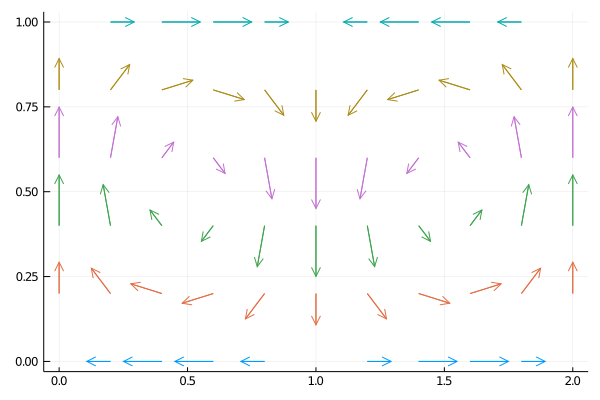

In [3]:
f = (x,y) -> double_gyre(x, y, 0,ϵ=0)./5  # scale down for visual purposes
quiver(X, Y', quiver=f)

For positive values of $\epsilon$ however, the size of both the gyres changes with period $\frac{\omega}{2\pi}$:

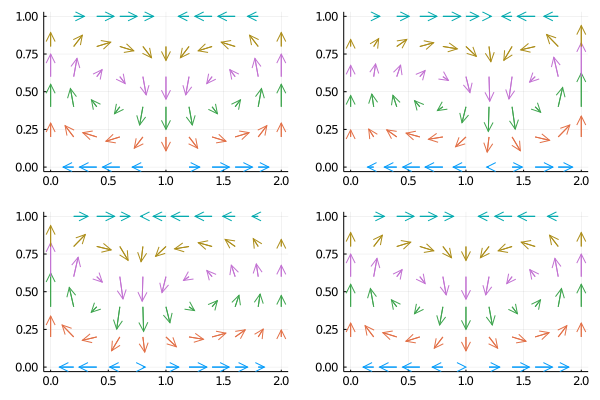

In [4]:
f_1 = (x,y) -> double_gyre(x, y, 0,ϵ=0.25)./5
f_2 = (x,y) -> double_gyre(x, y, 0.25,ϵ=0.25)./5 
f_3 = (x,y) -> double_gyre(x, y, 0.75,ϵ=0.25)./5
f_4 = (x,y) -> double_gyre(x, y, 1,ϵ=0.25)./5

p1 = quiver(X, Y', quiver=f_1)
p2 = quiver(X, Y', quiver=f_2)
p3 = quiver(X, Y', quiver=f_3)
p4 = quiver(X, Y', quiver=f_4)
Plots.plot(p1, p2, p3, p4, layout = (2,2))

As we are interested in the dynamics of this system, let's take a look at the paths of some random starting points (here `h` and `steps` are parameters for the numerical integration of the ODE. In particular, we will follow a particle up to time $T=\text{steps}\cdot h$):

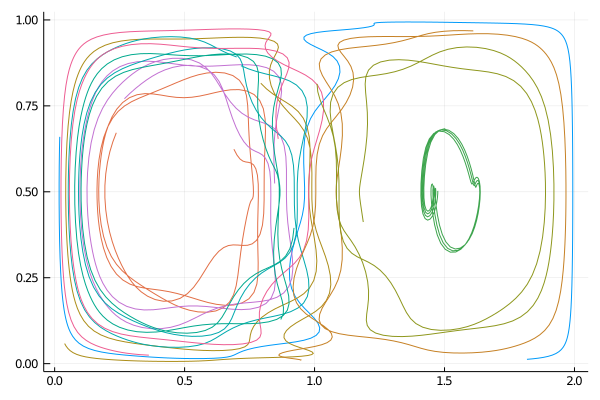

In [5]:
num_starting_points = 10
steps = 200
h = 0.05

seeds = rand(Float64,(2,num_starting_points))
seeds[1,:] = seeds[1,:].*2
path = [seeds[:,1]';double_gyre_map([seeds[:,1];0.0];steps=steps,h=h,return_intermediate=true)[:,1:2]]
Plots.plot(path[:,1],path[:,2],legend=false)
for i in 2:num_starting_points
    path = [seeds[:,i]';double_gyre_map([seeds[:,i];0.0];steps=steps,h=h,return_intermediate=true)[:,1:2]]
    Plots.plot!(path[:,1],path[:,2])
end
plot!()

We notice in particular that while most trajectories stay in one of the two gyres (at least if we do not choose the final time $T=\text{steps}\cdot\tau$ too large), some (may) also cross over, so the two regions of the state space are no longer completely invariant like they are for $\epsilon=0$.

As our goal is to find the structures governing the motion of the individual particles, we might be interested in following the paths of two close particles and see how they diverge over time:

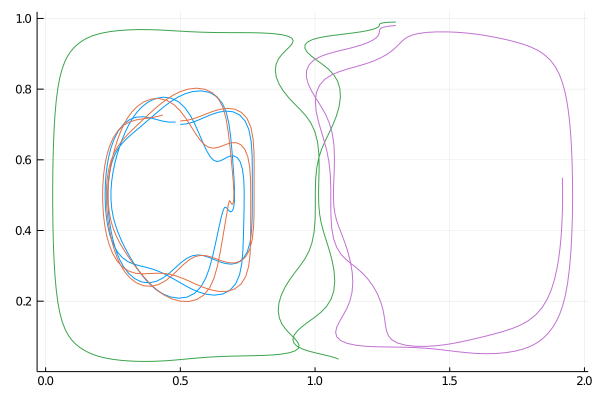

In [6]:
x = [0.5; 0.7; 0]
y = [0.5; 0.71; 0]
X = [x[1:2]'; double_gyre_map(x,steps=200;h=0.05,return_intermediate=true)[:,1:2]]
Y = [y[1:2]'; double_gyre_map(y,steps=200;h=0.05,return_intermediate=true)[:,1:2]]
Plots.plot(X[:,1],X[:,2], legend=false)
p1 = Plots.plot!(Y[:,1],Y[:,2])

x = [1.3; 0.99; 0]
y = [1.3; 0.98; 0]
X = [x[1:2]'; double_gyre_map(x,steps=200;h=0.05,return_intermediate=true)[:,1:2]]
Y = [y[1:2]'; double_gyre_map(y,steps=200;h=0.05,return_intermediate=true)[:,1:2]]
Plots.plot!(X[:,1],X[:,2])
Plots.plot!(Y[:,1],Y[:,2])

We notice that while the first pair of points stays fairly close for the whole interval $[0,T]$, the second one diverges and end up far apart. This is the central idea in defining ***Finite Time Lyapunov Exponents (FTLEs)***: For every point $x_0$ in the state space, we can calculate the largest FTLE $$\Lambda_T(x_0) := \frac{1}{T}\log{\sqrt{\lambda_{max}}},$$ where $\lambda_{max}$ is the largest eigenvalue of $(\frac{\partial \phi^T(x)}{\partial x}\rvert_{x=x_0})^T(\frac{\partial \phi^T(x)}{\partial x}\rvert_{x=x_0})$. The structures made up from the maximal values of this FTLE-field can now be shown to correspond (even though not exactly one to one) to the LCS of the system, which are influencing the dynamics.

To calculate an approximation for this continuous field of FTLE for a `BoxSet`, we can use the GAIO function `finite_time_lyapunov_exponents` (which, internally, estimates $\lambda_{max}$ by integrating close points and taking the maximal distance between two such points in a box) (Note: Depending on your machine, this might take some minutes. Performance parameters to tune are `depth`, `h` and `num_points`)

In [7]:
depth = 15
h = 0.25
num_points = 5

domain = Box(SVector(1.0,0.5),SVector(1.0,0.5))
partition = RegularPartition(domain,depth)
boxSet = partition[:]

t_0 = 0
T = 5
f = x -> double_gyre_map([x; t_0], h=h, steps=Int64(T/h), ω=2π, A=0.25, ϵ=0.25)
@time ftle = finite_time_lyapunov_exponents(boxSet, f, T=T, num_points=num_points, ϵ=1e-6)

 28.848898 seconds (233.07 M allocations: 9.644 GiB, 6.82% gc time)


BoxFun{RegularPartition{2,Float64},Int64,Float64}(RegularPartition{2,Float64}(Box{2,Float64}([1.0, 0.5], [1.0, 0.5]), 15, [0.0, 0.0], [128.0, 128.0], [256, 128], [1, 256]), Dict(9775 => 0.17798032228729757,22035 => 0.2360008379031216,6265 => 0.35943690175809656,1333 => 0.7152975472804384,3120 => 0.6096436461933276,9911 => 0.32054824998089837,11942 => 0.25222773229080814,19698 => 0.4568931345344078,29981 => 0.2884596047692777,10458 => 0.19374324466292409…))

To plot this field, we can simply select the highest FTLE values and collect them in a `BoxSet`: (**TODO**: Redo this once it is possible to plot this in colors corresponding to magnitude)

In [8]:
# This is a temporary solution but something similar (but better thought through)
# might be pretty cool to have (not just for plotting, but also to select sub-
# boxsets to further work with them)

function select_where(partition::BoxPartition,predicate::BoxFun)
    @assert predicate.partition == partition
    full_set = partition[:]
    points = []
    for box in full_set
        if predicate.dict[GAIO.point_to_key(partition,box.center)]
            push!(points,box.center)
        end
    end
    return partition[points]
end

select_where (generic function with 1 method)

In [9]:
GAIO.plot(select_where(partition,(x->x>0.5) ∘ ftle))

FTLE values will change depending on the initial time $t_0$ and the length of the interval $[t_0, t_0+T]$, highlighting how the dynamics evolve (again, we invite the reader to experiment with different values for all constants involved).

In [10]:
t_0 = 0.4
T = 5
f = x -> double_gyre_map([x;t_0], h=h, steps=Int64(T/h), ω=2π, A=0.25, ϵ=0.25)
ftle_2 = finite_time_lyapunov_exponents(boxSet, f, T=T, num_points=num_points, ϵ=1e-6);

In [11]:
GAIO.plot(select_where(partition,(x->x.>0.5) ∘ ftle_2))

The maxima (i.e. *ridges*) of the FTLE-field are known to correspond to ***repelling*** LCS. To get the ***attracting*** LCS, we can simply integrate the dynamical system in backward time (as our example is an incompressible two-dimensional flow, we could alternatively also follow the ideas in [1] and reuse the already computed exponents, but we will try to keep things simple and therefore use the standard approach here):

In [12]:
t_0 = 5
T = -5
f = x -> double_gyre_map([x;t_0], h=h, steps=Int64(abs(T)/h), ω=2π, A=0.25, ϵ=0.25, invert_time=true)
ftle_3 = finite_time_lyapunov_exponents(boxSet, f, T=T, num_points=num_points, ϵ=1e-6);

In [13]:
GAIO.plot(select_where(partition,(x->x.>0.5) ∘ ftle_3))

# References and Further Reading:

This short tutorial draws heavily from [this](https://shaddenlab.berkeley.edu/uploads/LCS-tutorial/index.html) tutorial from UC Berkeley and from the [FTLE](https://github.com/gaioguy/GAIO/blob/master/demos/ftle.m) and [double gyre map](https://github.com/gaioguy/GAIO/blob/master/demos/double_gyre_map.m) demos from the original GAIO implementation, and also uses ideas from the following two sources (the second of which provides a much more detailed analysis of the double gyre map, along with other examples):
- [1] Haller, G., & Sapsis, T. (2011). Lagrangian coherent structures and the smallest finite-time Lyapunov exponent. *Chaos: An Interdisciplinary Journal of Nonlinear Science, 21*(2), 023115.
- [2] Froyland, G., & Padberg, K. (2009). Almost-invariant sets and invariant manifolds—connecting probabilistic and geometric descriptions of coherent structures in flows. *Physica D: Nonlinear Phenomena, 238*(16), 1507-1523.